# 1. IMPORT DEPENDENCES

In [ ]:
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from keras.utils import np_utils
from tensorflow.keras.layers import Dense,Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers, optimizers
import tensorflow as tf
from tensorflow.keras.applications import ResNet50,VGG16,ResNet101, VGG19, DenseNet201, EfficientNetB4, MobileNetV2
from tensorflow.keras.applications import resnet, vgg16 , vgg19, densenet, efficientnet, mobilenet_v2
from tensorflow.keras import Model
from tensorflow.keras.optimizers.legacy import Adam
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import PIL
import os
import cv2



In [ ]:
tf.__version__

'2.12.0'

In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


rm: cannot remove '/root/.kaggle': No such file or directory
mv: cannot stat './kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/archive.zip -d Data

Archive:  /content/drive/MyDrive/archive.zip
  inflating: Data/Data/test/adenocarcinoma/000108 (3).png  
  inflating: Data/Data/test/adenocarcinoma/000109 (2).png  
  inflating: Data/Data/test/adenocarcinoma/000109 (4).png  
  inflating: Data/Data/test/adenocarcinoma/000109 (5).png  
  inflating: Data/Data/test/adenocarcinoma/000112 (2).png  
  inflating: Data/Data/test/adenocarcinoma/000113 (7).png  
  inflating: Data/Data/test/adenocarcinoma/000114 (5).png  
  inflating: Data/Data/test/adenocarcinoma/000114.png  
  inflating: Data/Data/test/adenocarcinoma/000115 (4).png  
  inflating: Data/Data/test/adenocarcinoma/000115 (8).png  
  inflating: Data/Data/test/adenocarcinoma/000115.png  
  inflating: Data/Data/test/adenocarcinoma/000116 (5).png  
  inflating: Data/Data/test/adenocarcinoma/000116 (7).png  
  inflating: Data/Data/test/adenocarcinoma/000116 (9).png  
  inflating: Data/Data/test/adenocarcinoma/000117 (4).png  
  inflating: Data/Data/test/adenocarcinoma/000117 (8).png  
  i

In [ ]:
path = "/content/Data/Data/train"
for files in os.listdir(path):
    print(os.path.join(path,files))

/content/Data/Data/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa
/content/Data/Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
/content/Data/Data/train/normal
/content/Data/Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa


In [ ]:
train_path = "/content/Data/Data/train"
valid_path = "/content/Data/Data/valid"
test_path = "/content/Data/Data/test"

In [ ]:
image_paths = ['/content/Data/Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa',
'/content/Data/Data/train/normal',
'/content/Data/Data/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa',
'/content/Data/Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib']

def load_images(image_paths = image_paths, n=36):
    # Load the images from disk.
    images = []
    for i in range(len(image_paths)):
        images_ = [cv2.imread(image_paths[i]+'/'+path) for path in os.listdir(image_paths[i])[:int(n/4)]]
        images.append(images_)
    # Convert to a numpy array and return it.
    sample = np.asarray(images)
    return sample


<ipython-input-8-a7055e1bdca8>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sample = np.asarray(images)


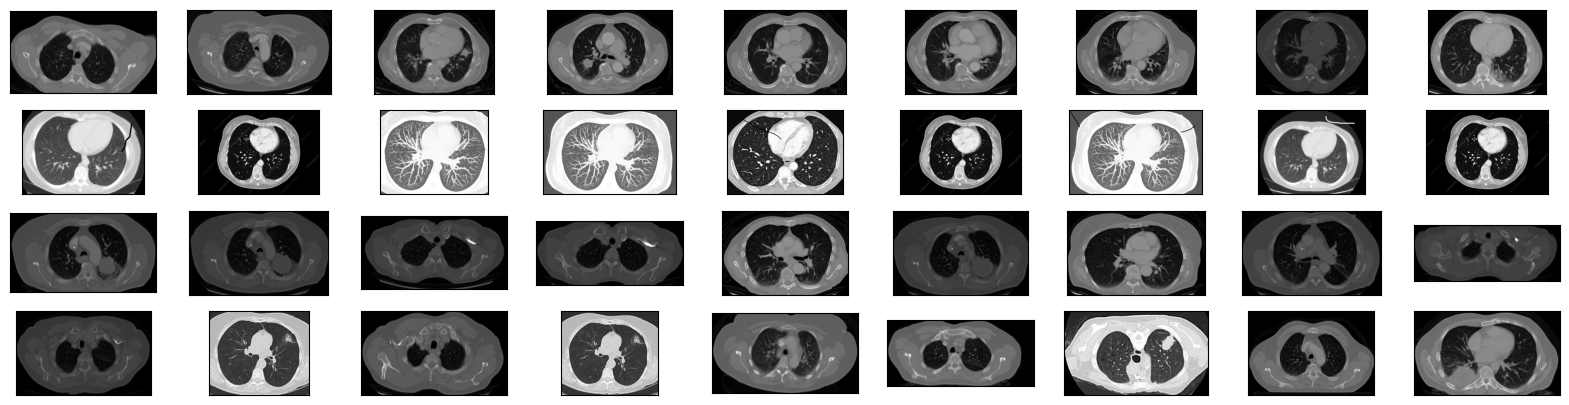

In [ ]:
sample = load_images()
fig = plt.figure(figsize=(20,5))
l = 1
shapes = []
for i in range(sample.shape[0]):
    for m in range(sample.shape[1]):
        ax = fig.add_subplot(4,9,m+l,xticks = [], yticks = [])
        ax.imshow(np.squeeze(sample[i,m]))
        shapes.append(sample[i,m].shape)
    l +=9

In [ ]:
np.array(shapes).mean(axis=0)


array([300.27777778, 468.44444444,   3.        ])

In [ ]:
image_shape = (305,430,3)
N_CLASSES = 4
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255.)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (305,430),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255.)
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (305,430),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32', rescale = 1.0/255.0)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (305,430),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [ ]:
base_hidden_units = 8
weight_decay = 1e-3
model = Sequential([

    Conv2D(filters = 8 , kernel_size = 2, padding = 'same', activation = 'relu', input_shape = image_shape),
    MaxPooling2D(pool_size = 2),
    
    Conv2D(filters = 16 , kernel_size = 2, padding = 'same', activation = 'relu',
           kernel_regularizer = regularizers.l2(weight_decay)),
    MaxPooling2D(pool_size = 2),
    
    
    Dropout(0.4),
    Flatten(),
    Dense(300,activation='relu'),
    Dropout(0.5),
    Dense(4,activation='softmax')
    
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 305, 430, 8)       104       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 152, 215, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 152, 215, 16)      528       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 76, 107, 16)      0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 76, 107, 16)       0         
                                                                 
 flatten (Flatten)           (None, 130112)            0

In [ ]:
checkpointer = ModelCheckpoint('chestmodel.hdf5',verbose=1, save_best_only= True)
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 15)
optimizer = Adam(lr=0.001, decay=1e-6)


model.compile(loss= 'categorical_crossentropy', optimizer= optimizer, metrics=['acc'])
history = model.fit(train_generator,
                    steps_per_epoch = 20,
                    epochs = 100,
                    verbose = 1,
                    validation_data = valid_generator,
                    callbacks = [checkpointer, early_stopping])

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 4.7365 - acc: 0.3719
Epoch 1: val_loss improved from inf to 1.19796, saving model to chestmodel.hdf5
20/20 [==============================] - 18s 436ms/step - loss: 4.7365 - acc: 0.3719 - val_loss: 1.1980 - val_acc: 0.4861
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 1.0326 - acc: 0.5644
Epoch 2: val_loss improved from 1.19796 to 0.89381, saving model to chestmodel.hdf5
20/20 [==============================] - 8s 389ms/step - loss: 1.0326 - acc: 0.5644 - val_loss: 0.8938 - val_acc: 0.5278
Epoch 3/100
20/20 [==============================] - ETA: 0s - loss: 0.6938 - acc: 0.7553
Epoch 3: val_loss improved from 0.89381 to 0.82468, saving model to chestmodel.hdf5
20/20 [==============================] - 7s 338ms/step - loss: 0.6938 - acc: 0.7553 - val_loss: 0.8247 - val_acc: 0.5556
Epoch 4/100
20/20 [==============================] - ETA: 0s - loss: 0.4552 - acc: 0.8352
Epoch 4: val_loss improved f

In [ ]:
result = model.evaluate(test_generator)

10/10 [==============================] - 3s 256ms/step - loss: 2.1638 - acc: 0.5492


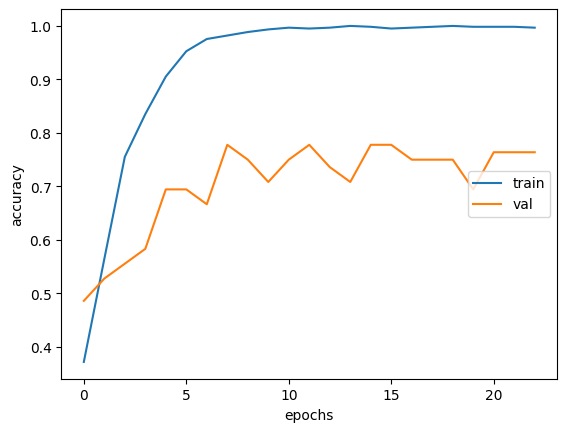

In [ ]:
plt.plot(history.history['acc'], label = 'train',)
plt.plot(history.history['val_acc'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

## VGG

In [ ]:
image_shape = (460,460,3)
N_CLASSES = 4
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(dtype='float32', rescale=1./255.)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32',  rescale=1./255.)
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32',  rescale=1./255.)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [ ]:
vgg_model = VGG16(include_top=False, pooling='avg', weights='imagenet', input_shape = (image_shape))
for layer in vgg_model.layers:
    layer.trainable = False


58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
model = Sequential()
model.add(vgg_model)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(N_CLASSES, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 14,718,788
Trainable params: 3,076
Non-trainable params: 14,715,712
_________________________________________________________________


In [ ]:
optimizer = Adam(lr=0.001, decay=1e-6)
model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['acc'])

In [ ]:
checkpointer = ModelCheckpoint(filepath='./chest_CT_SCAN-/vgg16.hdf5',
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=15)

In [ ]:
history_vgg = model.fit(train_generator,
                    steps_per_epoch = 20,
                    epochs = 100,
                    verbose = 1,
                    validation_data = valid_generator,
                    callbacks = [checkpointer, early_stopping])

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 1.0239 - acc: 0.5449
Epoch 1: val_loss improved from inf to 1.66919, saving model to ./chest_CT_SCAN-/vgg16.hdf5
20/20 [==============================] - 36s 1s/step - loss: 1.0239 - acc: 0.5449 - val_loss: 1.6692 - val_acc: 0.2083
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 0.8295 - acc: 0.6672
Epoch 2: val_loss improved from 1.66919 to 1.58347, saving model to ./chest_CT_SCAN-/vgg16.hdf5
20/20 [==============================] - 12s 613ms/step - loss: 0.8295 - acc: 0.6672 - val_loss: 1.5835 - val_acc: 0.2083
Epoch 3/100
20/20 [==============================] - ETA: 0s - loss: 0.7308 - acc: 0.7178
Epoch 3: val_loss improved from 1.58347 to 1.54076, saving model to ./chest_CT_SCAN-/vgg16.hdf5
20/20 [==============================] - 13s 622ms/step - loss: 0.7308 - acc: 0.7178 - val_loss: 1.5408 - val_acc: 0.2083
Epoch 4/100
20/20 [==============================] - ETA: 0s - loss: 0.6737 - acc: 

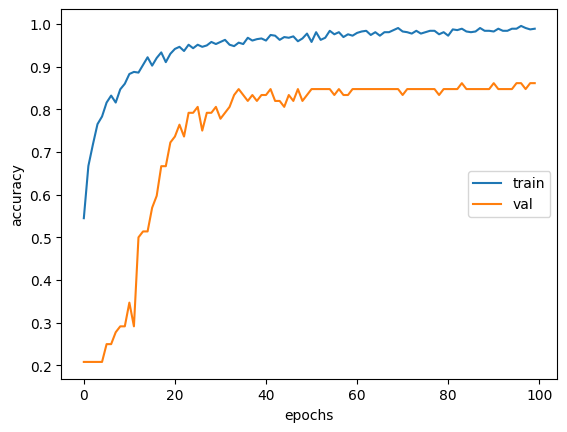

In [ ]:
plt.plot(history_vgg.history['acc'], label = 'train',)
plt.plot(history_vgg.history['val_acc'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [ ]:
result = model.evaluate(test_generator)

10/10 [==============================] - 20s 2s/step - loss: 0.4604 - acc: 0.8381
